### ETF Cross-Sectional Mean Reversion

The strategy looks at the cross-sectional performance of 4 different ETFs. The ETFs have been chosen so that they
represent different industry sectors. We buy the ones that have had the lowest relative performance over the recent
period, expecting their fortunes to reverse and for them to outperform going forward. This is a cross-sectional mean reversion of returns. The strategy is long-only so does not take
any short posiitons.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime

pd.set_option('display.width', 320)
% matplotlib inline

In [2]:
#########
# Symbols
#########

# XAR = aerospace & defense
# IYM = basic materials
# IDU = utilities
# SOXX = semiconductors

source = 'morningstar'
start = datetime(2011, 1, 1)
end = datetime(2018, 3, 31)

xar = web.DataReader('XAR', source, start, end)
xar.index = xar.index.droplevel(level=0)

iym = web.DataReader('IYM', source, start, end)
iym.index = iym.index.droplevel(level=0)

idu = web.DataReader('IDU', source, start, end)
idu.index = idu.index.droplevel(level=0)

soxx = web.DataReader('SOXX', source, start, end)
soxx.index = soxx.index.droplevel(level=0)

In [3]:
# Create common index
# (This is a naive way to address the problem of potential missing data in some 
# of the ETF time series)

common_index = xar.index.intersection(iym.index)
common_index = common_index.intersection(idu.index)
common_index = common_index.intersection(soxx.index)

In [4]:
# Create combined DataFrame

df = pd.DataFrame(index=common_index)
df[('xar', 'price')] = xar['Close']
df[('iym', 'price')] = iym['Close']
df[('idu', 'price')] = idu['Close']
df[('soxx', 'price')] = soxx['Close']
df.columns = pd.MultiIndex.from_tuples(df.columns)

In [5]:
# Get daily percentage change for each ETF and rank them

etf_list = ['xar', 'iym', 'idu', 'soxx']

for etf in etf_list:
    df[(etf, 'pct_change')] = df[(etf, 'price')].pct_change()

pct_change_df = df.xs('pct_change', level=1, axis=1)
rank_df = pct_change_df.rank(axis=1)

rank_df.head()

,xar,iym,idu,soxx
Date,,,,
2011-09-28,NaN,NaN,NaN,NaN
2011-09-29,3.0,2.0,4.0,1.0
2011-09-30,3.0,1.0,4.0,2.0
2011-10-03,4.0,2.0,3.0,1.0
2011-10-04,1.0,3.0,2.0,4.0


The ETFs are now ranked 1-4, with 4 being the highest percentage return and 1 being the lowest.

We will take long positions in the two lowest ranked ETFs, expecting their performance to mean-revert and outperform
going forward. This means the portfolio naturally re-balances whenever the ranking of the two lowest ETFs changes.

We will put two-thirds of the portfolio in the lowest ranking ETF and one-third in the second lowest. The other two
ETFs will have no position. We therefore stay 100% invested at all times.  

This position sizing logic is achieved
by the below:

In [6]:
def position_sizing(etf):
    lagged_rank = df[(etf, 'rank')].shift(1)
    return lagged_rank.apply(lambda x: (3 - x) / 3 if x < 3 else 0)

In [7]:
for etf in etf_list:
    df[(etf, 'rank')] = rank_df[etf]
    df[(etf, 'position')] = position_sizing(etf)
    df[(etf, 'pnl')] = (df[(etf, 'position')]) * df[(etf, 'pct_change')]

df.sort_index(level=0, axis=1, inplace=True)

In [8]:
# Now aggregate up to the portfolio level

df[('portfolio', 'position')] = df.xs('position', level=1, axis=1).sum(axis=1) # Note: this will always be 1 (check)
df[('portfolio', 'pnl')] = df[etf_list].xs('pnl', level=1, axis=1).sum(axis=1)
df[('portfolio', 'equity')] = (1 + df[('portfolio', 'pnl')]).cumprod()

0.08737498998543304

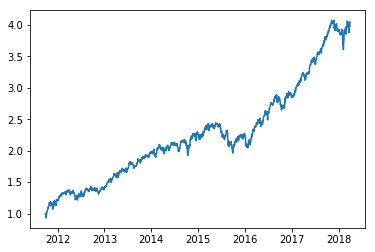

In [13]:
# Plot the portfolio return:

plt.plot(df[('portfolio', 'equity')])
df[('portfolio', 'pnl')].mean() * 100

Next we compute the Sharpe Ratio

In [14]:
def sharpe(pnl):
    return pnl.mean() / pnl.std() * np.sqrt(252)

In [31]:
print 'Sharpe Ratio: ', sharpe(df[('portfolio', 'pnl')]).round(2)

Sharpe Ratio:  1.39


In [16]:
# Other performance metrics
def drawdown(equity):
    drawdown_profile = pd.Series(index=equity.index)
    hwm = 1
    for index, val in equity.iteritems():
        drawdown = min((val - hwm) / hwm, 0)
        hwm = max(hwm, val)
        drawdown_profile.loc[index] = drawdown
    return drawdown_profile

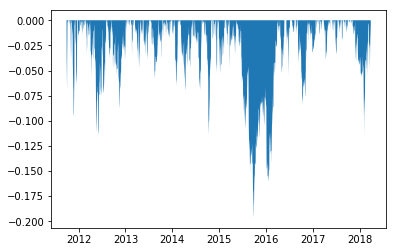

In [17]:
dd_profile = drawdown(df[('portfolio', 'equity')])
plt.fill_between(dd_profile.index, 0, dd_profile.values)

The drawdown profile shows us the percentage drawdowns from peaks that we would have endured if we were trading the strrategy. We can see that there are frequent drawdowns of around 5% and a severe drawdown in the second half of 2015 of more than 19%

In [32]:
print 'Max Drawdown: ', dd_profile.min().round(3)

Max Drawdown:  -0.197


Finally let's compare our strategy to the performance of a stock market benchmark. We will use the Russell 3000 index, ticker = "IWV"

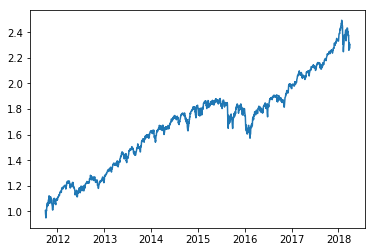

In [22]:
russ = web.DataReader('IWV', source, start, end)
russ.index = russ.index.droplevel(level=0)
russ = pd.merge(russ, pd.DataFrame(common_index, index=common_index), 
                how='inner', left_index=True, right_index=True)
benchmark_pnl = russ['Close'].pct_change()
plt.plot((1 + benchmark_pnl).cumprod())

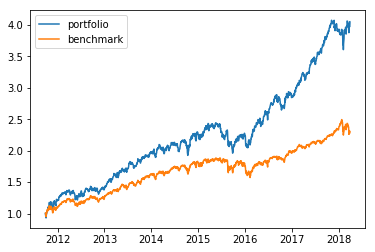

In [25]:
# Plotting the portfolio and the benchmark side by side:

plt.plot(df[('portfolio', 'equity')], label='portfolio')
plt.plot((1 + benchmark_pnl).cumprod(), label='benchmark')
plt.legend(loc='best')

We can see that the total return of the strategy of simply investing in the Russell 3000 was 140% ((2.4 - 1.0)/1.0) while the return to our ETF strategy was 300%

We can get a better idea of our "active return" i.e. our return over and above the benchmark, by subtracting the benchmark return from the portfolio return. This is the basis for the Information Ratio which we also calculate below. 

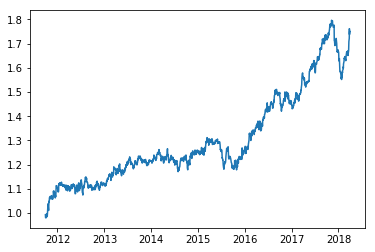

In [23]:
active_return = df[('portfolio', 'pnl')] - benchmark_pnl
plt.plot((1 + active_return).cumprod())

In [33]:
# Information ratio is simply the Sharpe Ratio of the *active* return

print 'Information ratio: ', sharpe(active_return).round(2)

Information ratio:  0.94
